# **MILESTONE 1 i 2**


## **Cel biznesowy:** Segmentacja klientów banku na podstawie ich zachowań transakcyjnych i typów kont w celu personalizacji ofert marketingowych i zwiększenia retencji klientów

**Korzyści wynikające dla banku z racji takiego pogrupowania klientów:**

- Możliwość kierowania odpowiednich ofert do odpowiednich klientów (np. lokaty dla klientów z dużym saldem).

- Identyfikacja klientów wysokiego ryzyka lub niskiej aktywności.

- Możliwość tworzenia kampanii retencyjnych dla segmentów o niskim zaangażowaniu.

### Wczytanie ramki danych

In [515]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/banking_dataset.csv")

## **Eksploracja i wstępna analiza danych**

In [516]:
df.head()

,,Account ID;Customer Name;Account Type;Branch;Transaction Type;Transaction Amount;Account Balance;Currency
ACC00001;Amanda Pugh;Recurring Deposit;New York;Debit;2687,19;36676,19;GBP
ACC00002;Amanda Wilcox;Recurring Deposit;Houston;Debit;3886,77;28582,82;USD
ACC00003;Kimberly Valenzuela;Current;New York;Credit;2438,74;76599,56;GBP
ACC00004;Sonia Ballard;Recurring Deposit;Philadelphia;Credit;2758,53;62317,6;INR
ACC00005;Erika Russell;Current;Philadelphia;Debit;3287;85515,21;INR,NaN


Widzimy, że ramka danych po zapisaniu w pliku csv, nie ładuje się dobrze. Na szczęście jest na to rozwiązanie:

In [517]:
df = pd.read_csv("data/banking_dataset.csv", sep=";")


In [518]:
df.head()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,ACC00001,Amanda Pugh,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,ACC00002,Amanda Wilcox,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,ACC00003,Kimberly Valenzuela,Current,New York,Credit,"2438,74","76599,56",GBP
3,ACC00004,Sonia Ballard,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,ACC00005,Erika Russell,Current,Philadelphia,Debit,3287,"85515,21",INR


In [519]:
df.tail()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
9995,ACC09996,Richard Davis,Fixed Deposit,New York,Debit,"400,96","38035,17",USD
9996,ACC09997,Lauren Weber,Savings,Chicago,Debit,"3736,7","60682,41",EUR
9997,ACC09998,Nichole Stout,Fixed Deposit,Houston,Credit,"4002,91","36136,11",USD
9998,ACC09999,Kristen Wilkinson,Fixed Deposit,Philadelphia,Debit,"866,9","35644,82",GBP
9999,ACC10000,Brian Sandoval,Fixed Deposit,Philadelphia,Debit,"3932,81","32357,51",GBP


In [520]:
df.shape

(10000, 8)

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Account ID          10000 non-null  object
 1   Customer Name       10000 non-null  object
 2   Account Type        10000 non-null  object
 3   Branch              10000 non-null  object
 4   Transaction Type    10000 non-null  object
 5   Transaction Amount  10000 non-null  object
 6   Account Balance     10000 non-null  object
 7   Currency            10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


wszysktie kolumny są typu object - trzeba będzie to zmienić 

In [522]:
print(df.isnull().sum())

Account ID            0
Customer Name         0
Account Type          0
Branch                0
Transaction Type      0
Transaction Amount    0
Account Balance       0
Currency              0
dtype: int64


Brak pustych wartości

In [523]:
df.describe()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,9323,4,8,2,9896,9995,5
top,ACC00001,William Williams,Savings,Philadelphia,Credit,"3398,97","21317,69",JPY
freq,1,7,2580,1288,5114,3,2,2041


## Po wstępnej analizie kolumn, usunięte zostaną kolumny 'Account ID' oraz 'Customer Name', są to informacje, które nie wnoszą żadnej informacji

komentarz: czy na pewno accountID? Czy nie warto zostawić dla samego celu identyfikacyjnego konta?

In [524]:
df = df.drop(['Account ID', 'Customer Name'], axis = 1)

In [525]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,Current,New York,Credit,"2438,74","76599,56",GBP
3,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,Current,Philadelphia,Debit,3287,"85515,21",INR


In [526]:
df.drop_duplicates(inplace=True) #to może nie być poprawne

Możemy teraz przejść do dalszej eksploracji danych, najpierw zmieńmy typy danych w kolumnach, aby móc operować na zmiennych liczbowych

In [527]:
#df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'], errors='coerce')
#df['Account Balance'] = pd.to_numeric(df['Account Balance'], errors='coerce')

df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

^ tutaj był błąd, zakomentowany kod psuł tabelę

Sprawdźmy unikalne wartości i ich ilość dla poszczególnych kolumn

In [528]:
print(df.dtypes)

Account Type           object
Branch                 object
Transaction Type       object
Transaction Amount    float64
Account Balance       float64
Currency               object
dtype: object


In [529]:
for col in ['Account Type', 'Branch', 'Transaction Type', 'Currency']:
    print(f"\nUnikalne wartości w kolumnie {col}:")
    print(df[col].value_counts())


Unikalne wartości w kolumnie Account Type:
Account Type
Savings              2580
Current              2529
Fixed Deposit        2489
Recurring Deposit    2402
Name: count, dtype: int64

Unikalne wartości w kolumnie Branch:
Branch
Philadelphia    1288
Phoenix         1274
Los Angeles     1268
Houston         1259
New York        1256
Chicago         1239
San Antonio     1233
San Diego       1183
Name: count, dtype: int64

Unikalne wartości w kolumnie Transaction Type:
Transaction Type
Credit    5114
Debit     4886
Name: count, dtype: int64

Unikalne wartości w kolumnie Currency:
Currency
JPY    2041
EUR    2039
USD    2035
GBP    1958
INR    1927
Name: count, dtype: int64


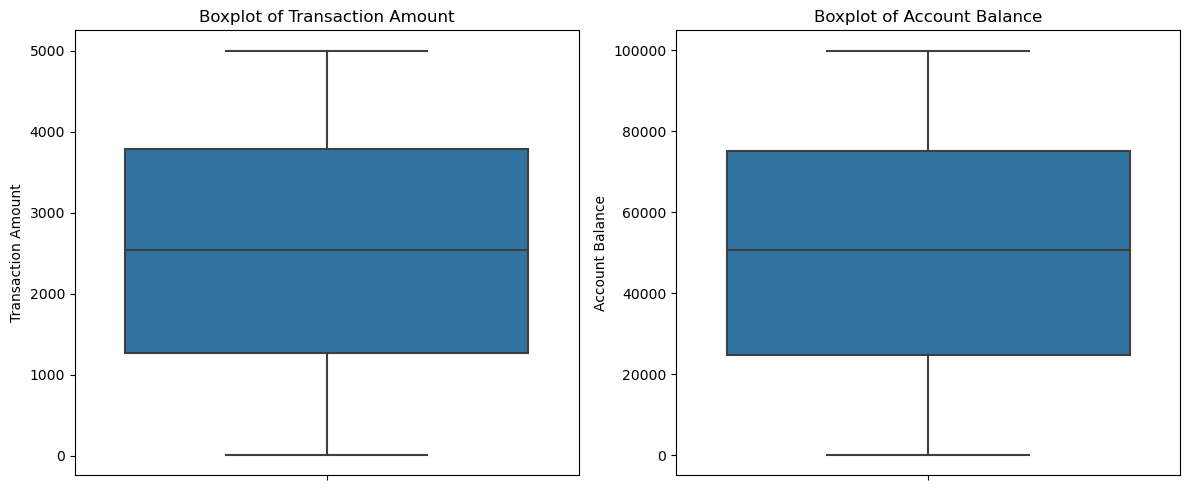

In [530]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

**Nie ma widocznych żadnych outlierów.**

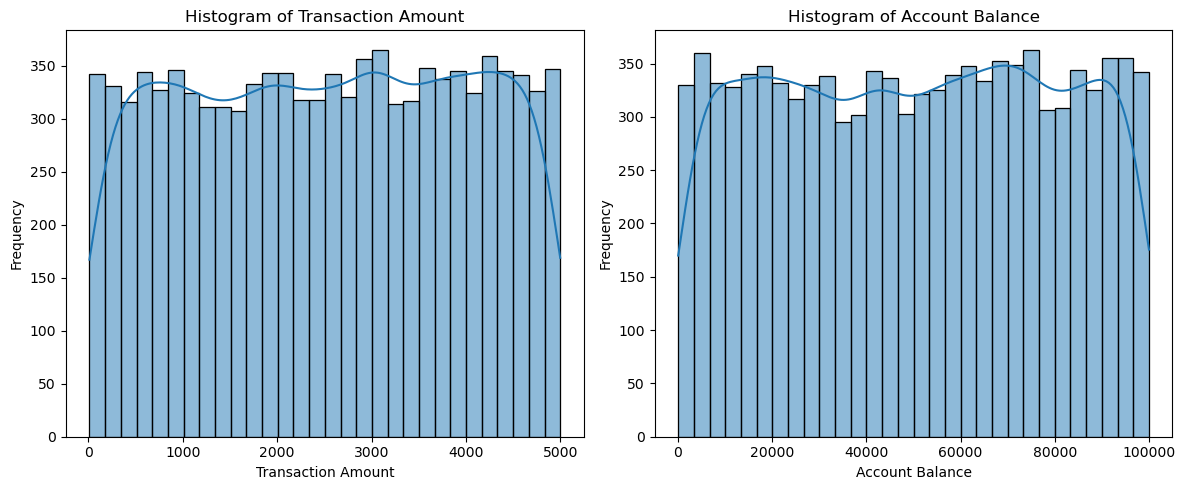

In [531]:
plt.figure(figsize=(12, 5))

# Transaction amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Acc balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance'], bins=30, kde=True)
plt.title('Histogram of Account Balance')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

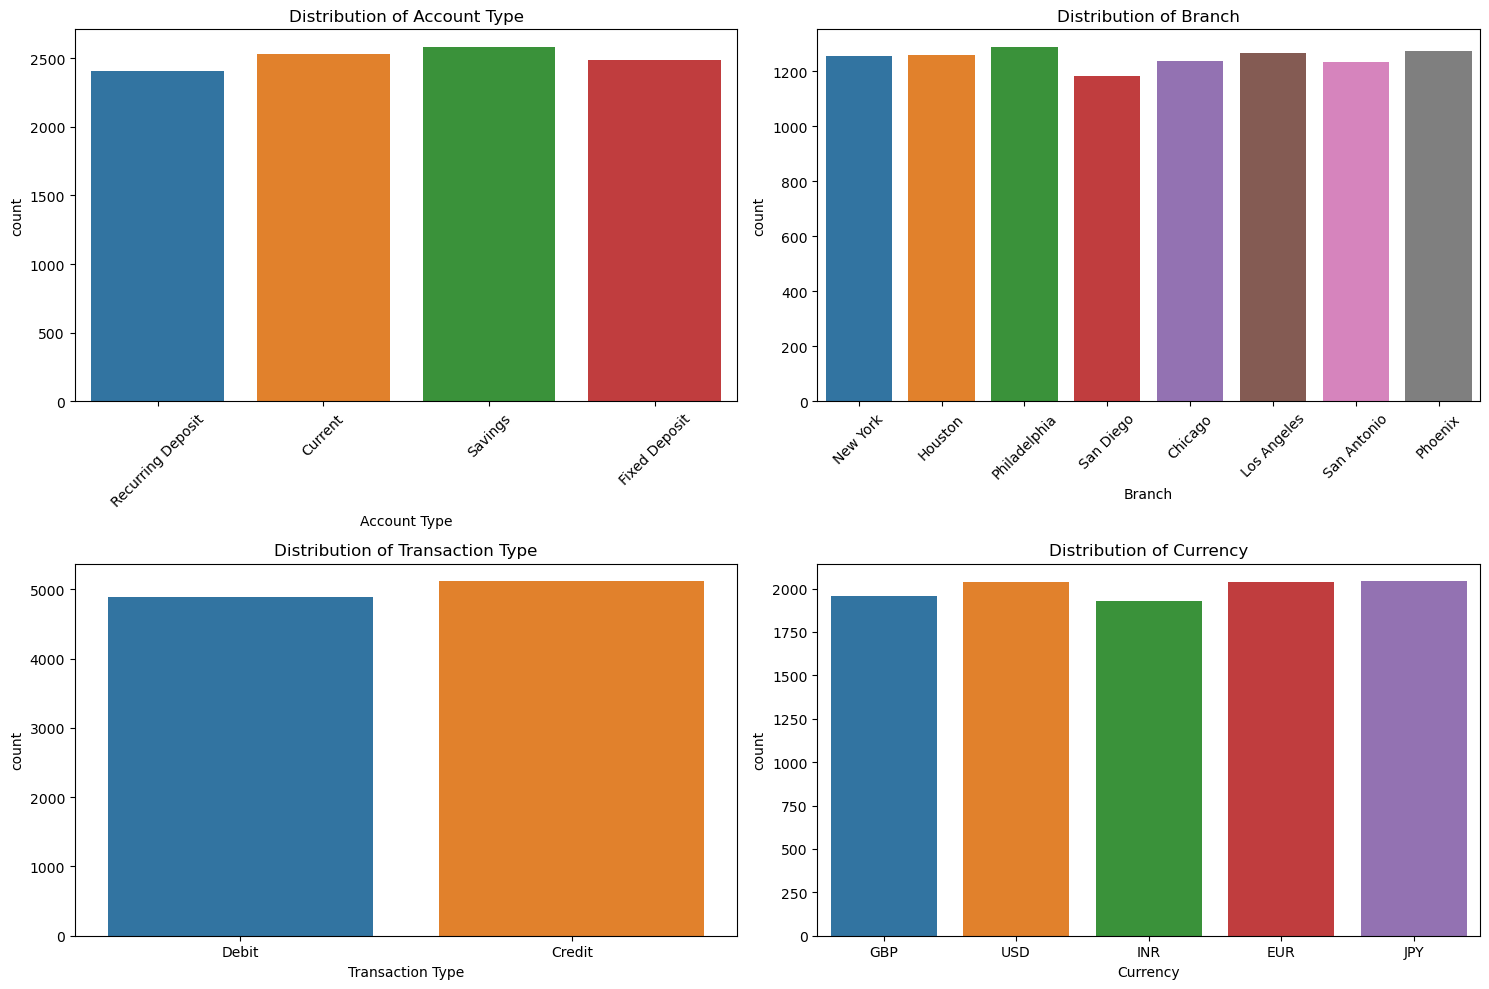

In [532]:
# Count plots for categorical variables
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='Account Type', data=df)
plt.title('Distribution of Account Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=df)
plt.title('Distribution of Branch')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.countplot(x='Transaction Type', data=df)
plt.title('Distribution of Transaction Type')

plt.subplot(2, 2, 4)
sns.countplot(x='Currency', data=df)
plt.title('Distribution of Currency')
plt.tight_layout()
plt.show()


Dla każdej zmiennej kategorycznej zliczenia możliwych wartości są rozłożone mniej więcej po równo.

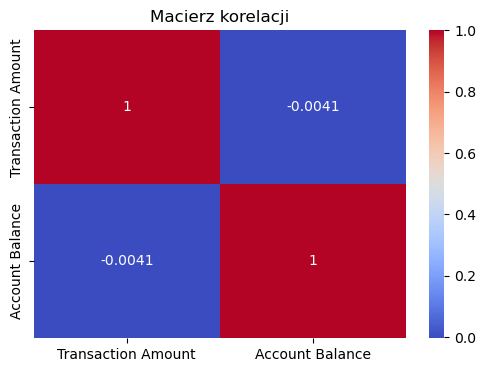

In [533]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

Macierz korelacji

In [534]:
print(df.groupby('Account Type')['Transaction Amount'].mean())

print(df.groupby('Currency')['Account Balance'].mean())


Account Type
Current              2502.820059
Fixed Deposit        2546.617151
Recurring Deposit    2512.312627
Savings              2536.010089
Name: Transaction Amount, dtype: float64
Currency
EUR    50502.715473
GBP    49906.100516
INR    51049.621271
JPY    49827.480314
USD    50091.525027
Name: Account Balance, dtype: float64


Nie widać na piewrszy rzut oka żadnej zależności pomiędzy średnią wartością transakcji/stanem konta a walutą w jakiej prowadzone jest konto

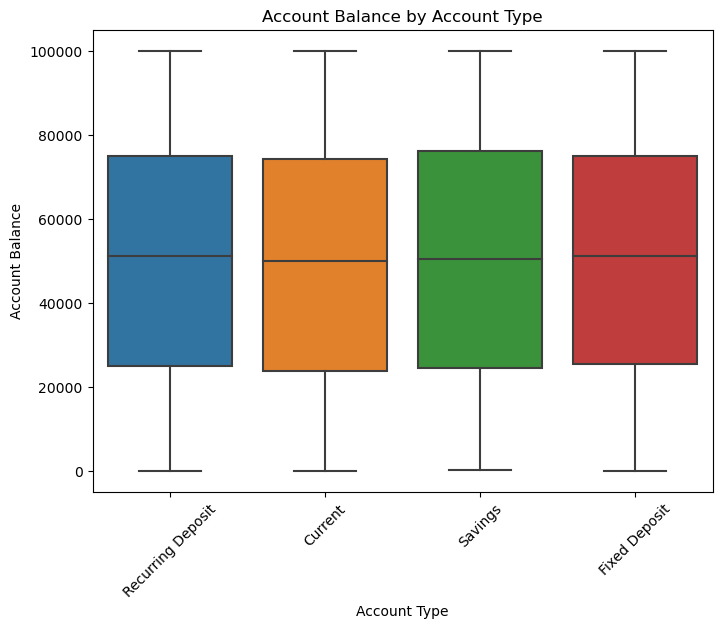

In [535]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Account Type', y='Account Balance', data=df)
plt.title('Account Balance by Account Type')
plt.xticks(rotation=45)
plt.show()

Brak outlierów. Rozkład stanu konta w zależności od typu konta

In [536]:
# Cross-tabulation of Account Type and Transaction Type
print(pd.crosstab(df['Account Type'], df['Transaction Type']))

Transaction Type   Credit  Debit
Account Type                    
Current              1323   1206
Fixed Deposit        1266   1223
Recurring Deposit    1206   1196
Savings              1319   1261


Po równo.

# **Inżynieria cech**

## **Zamiana na jedną walutę i ponowne przeprowadzenie analizy**

In [537]:
exchange_rates = {'USD': 1.0, 'EUR': 1.08, 'GBP': 1.27, 'INR': 0.012, 'JPY': 0.0066}

# Zamiana na USD
df['Transaction Amount USD'] = df.apply(lambda x: float(x['Transaction Amount']) * exchange_rates.get(x['Currency'], 1.0), axis=1)
df['Account Balance USD'] = df.apply(lambda x: float(x['Account Balance']) * exchange_rates.get(x['Currency'], 1.0), axis=1)

# sprawdzamy czy dizała
print(df[['Transaction Amount USD', 'Account Balance USD']].describe())


       Transaction Amount USD  Account Balance USD
count            10000.000000         10000.000000
mean              1704.556596         33910.047464
std               1870.159242         37213.913721
min                  0.082434             0.897336
25%                 26.736683           535.726967
50%                950.329000         18802.265000
75%               3277.854375         65177.548200
max               6347.510800        126968.999300


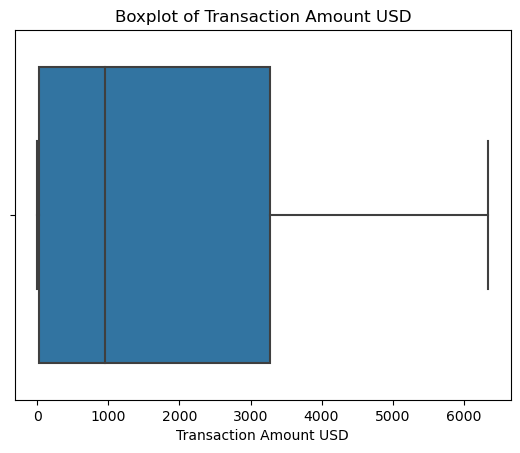

In [538]:
sns.boxplot(x=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount USD')
plt.show()

brak outlierów

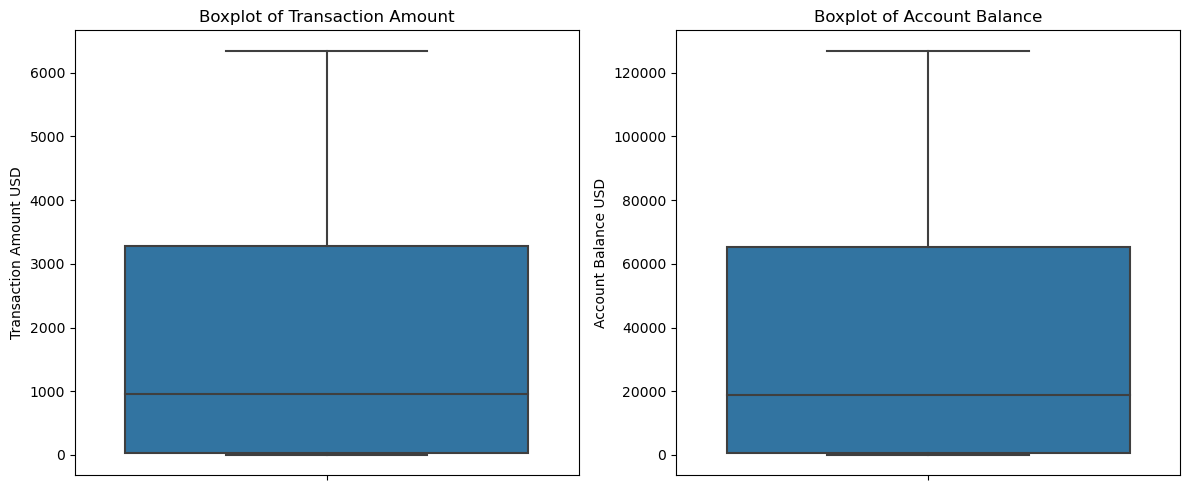

In [539]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance USD'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

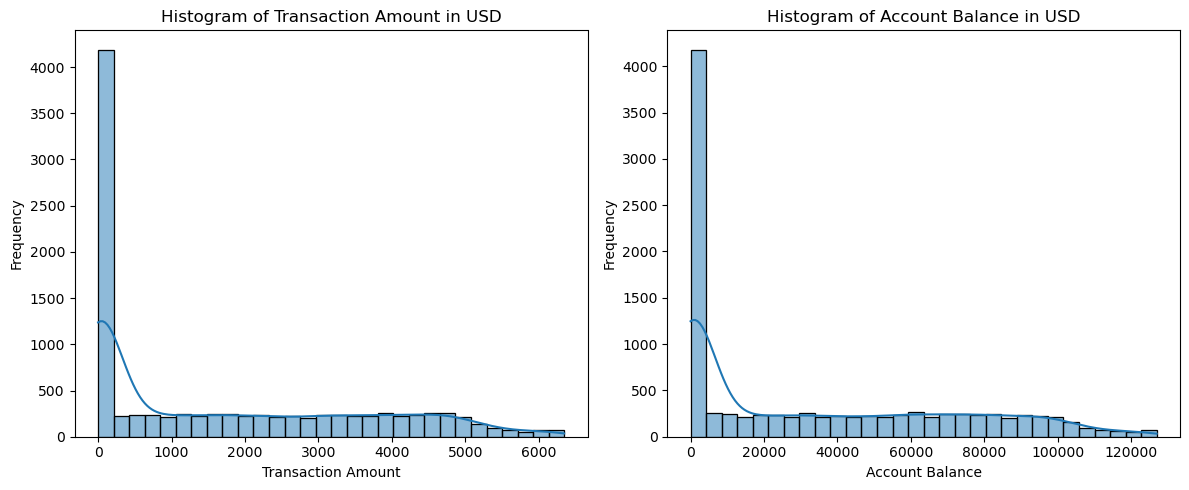

In [540]:
plt.figure(figsize=(12, 5))

# Histogram dla Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount USD'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount in USD')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram dla Account Balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance USD'], bins=30, kde=True)
plt.title('Histogram of Account Balance in USD')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Bardzo mocna skośność, można rozważyć logarytmowanie - lub wykluczenie zmiennej (nwm)

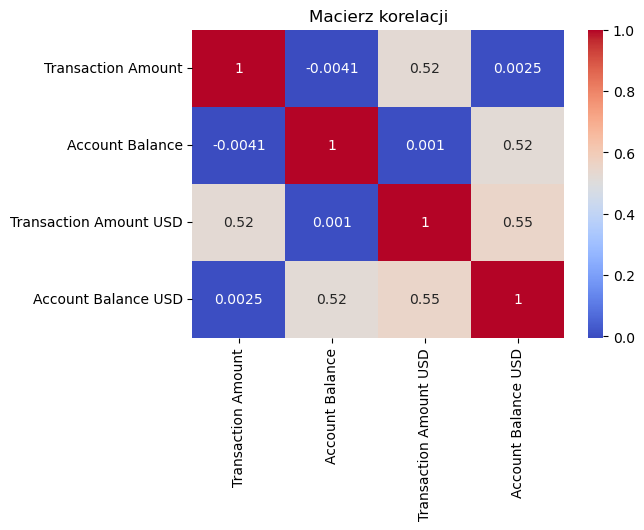

In [541]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

**Przeskalowanie wartości** dla wartości numerycznych sprowadzając wszystko do jednej waluty daje ciekawe informacje. Jednak mimo wszystko wydaje się, że może być to mało wartościowa zmienna.

komentarz: dla mnie spoko

## Nowa zmienna

In [542]:
df['Balance_to_Transaction_Ratio'] = df['Account Balance'] / df['Transaction Amount']

może być wrażliwe na outliery

Text(0, 0.5, 'Frequency')

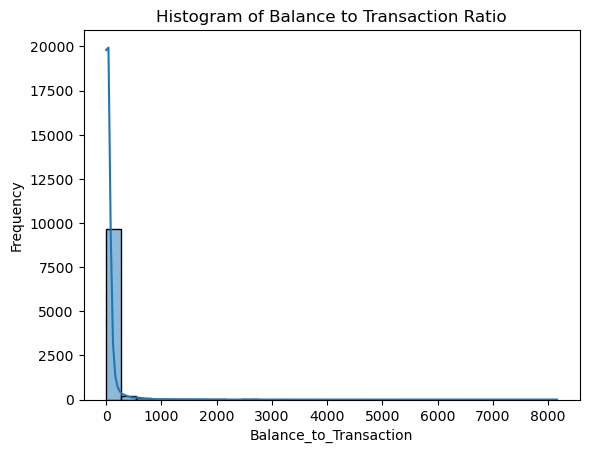

In [543]:
sns.histplot(df['Balance_to_Transaction_Ratio'], bins=30, kde=True)
plt.title('Histogram of Balance to Transaction Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

In [544]:
df['Log_Balance_to_Transaction_Ratio'] = np.log1p(df['Balance_to_Transaction_Ratio'].clip(lower=1e-6))

Text(0, 0.5, 'Frequency')

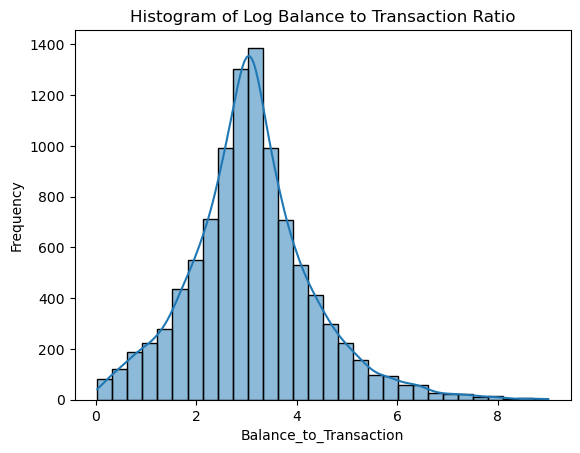

In [545]:
sns.histplot(df['Log_Balance_to_Transaction_Ratio'], bins=30, kde=True)
plt.title('Histogram of Log Balance to Transaction Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

In [546]:
print(df[df['Account Balance USD'] < 0].shape)  
print(df[df['Transaction Amount USD'] <= 0].shape)  

(0, 10)
(0, 10)


brak ujemnych sald

## To samo tylko w drugą stronę

In [547]:
df['Transaction_To_Balance_Ratio'] = df['Transaction Amount'] / df['Account Balance']

Text(0, 0.5, 'Frequency')

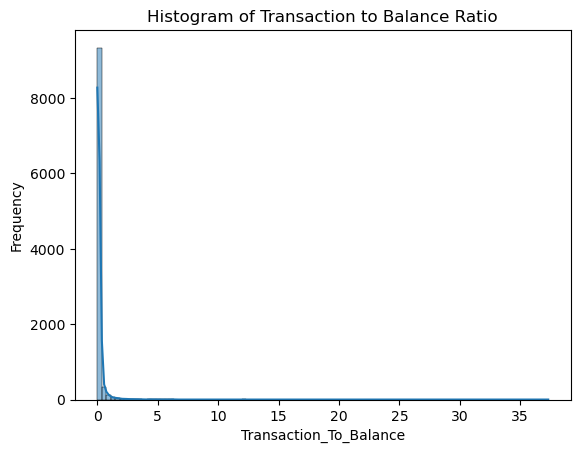

In [548]:
sns.histplot(df['Transaction_To_Balance_Ratio'], bins=100, kde=True)
plt.title('Histogram of Transaction to Balance Ratio')
plt.xlabel('Transaction_To_Balance')
plt.ylabel('Frequency')

In [549]:
df['Log_Transaction_To_Balance_Ratio'] = np.log1p(df['Transaction_To_Balance_Ratio'].clip(lower=1e-6))

Text(0, 0.5, 'Frequency')

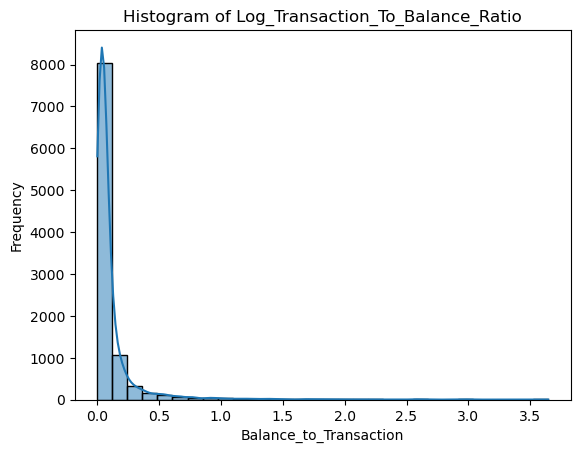

In [550]:
sns.histplot(df['Log_Transaction_To_Balance_Ratio'], bins=30, kde=True)
plt.title('Histogram of Log_Transaction_To_Balance_Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

Wygląda gorzej, ale jest bardziej intuicujna. Pod utworzymy tą zmienną ale na USD. Będzie miała nazwę Activity Ratio

In [551]:
df = df.drop(['Log_Transaction_To_Balance_Ratio'], axis=1)

Zmiana zmiennych kategorycznych

In [552]:
df['Transaction Type'] = df['Transaction Type'].map({'Debit': 0, 'Credit': 1})

In [553]:
df['Activity_Ratio'] = df['Account Balance USD'] / (df['Transaction Amount USD'] + 1)
df['Log_Activity_Ratio'] = np.log1p(df['Activity_Ratio'].clip(lower=1e-6))

Zmienne odpowiadające za to czy ktoś robi więcej dużych czy mniej transakcji.

In [554]:
df['Account_Type_Original'] = df['Account Type'].copy()
df = pd.get_dummies(df, columns=['Account Type'], prefix='Account_Type')
df['Account_Balance_Relative_to_Mean_AccType'] = df['Account Balance USD'] / df.groupby('Account_Type_Original')['Account Balance USD'].transform('mean')
df = df.drop('Account_Type_Original', axis=1)

Zmienna mówiąca o tym, czy ktoś o danym typie konta ma większy czy mniejszy stan konta

In [555]:
df['Transaction_Type_Original'] = df['Transaction Type'].copy()
df = pd.get_dummies(df, columns=['Transaction Type'], prefix='Transaction_Type')
df['Transaction_Amount_Relative_to_Mean_TransType'] = df['Transaction Amount USD'] / df.groupby('Transaction_Type_Original')['Transaction Amount USD'].transform('mean')
df = df.drop('Transaction_Type_Original', axis=1)

Zmienna mówiąca o tym czy dana transakcja była większa czy mniejsza od średniej transakcji w zależności od typu transakcji

In [556]:
df = pd.get_dummies(df, columns=['Currency'], prefix='Currency')

In [557]:
df.describe()

,Transaction Amount,Account Balance,Transaction Amount USD,Account Balance USD,Balance_to_Transaction_Ratio,Log_Balance_to_Transaction_Ratio,Transaction_To_Balance_Ratio,Activity_Ratio,Log_Activity_Ratio,Account_Balance_Relative_to_Mean_AccType,Transaction_Amount_Relative_to_Mean_TransType
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2524.564298,50269.794260,1704.556596,33910.047464,61.379967,3.093531,0.173226,51.598017,3.053764,1.000000,1.000000
std,1444.318039,29057.726646,1870.159242,37213.913721,252.298729,1.220871,0.910253,188.571262,1.178313,1.097756,1.097354
min,10.970000,101.890000,0.082434,0.897336,0.026799,0.026447,0.000122,0.026793,0.026440,0.000027,0.000049
25%,1263.912500,24863.487500,26.736683,535.726967,9.917744,2.390389,0.025296,9.700183,2.370261,0.015856,0.015674
50%,2544.655000,50790.475000,950.329000,18802.265000,19.914487,3.040442,0.050215,19.591474,3.024877,0.551807,0.555584
75%,3781.757500,75128.187500,3277.854375,65177.548200,39.532359,3.702101,0.100829,38.292693,3.671039,1.917627,1.922620
max,4999.790000,99975.590000,6347.510800,126968.999300,8163.276436,9.007523,37.314359,7535.814758,8.927555,3.847178,3.775900


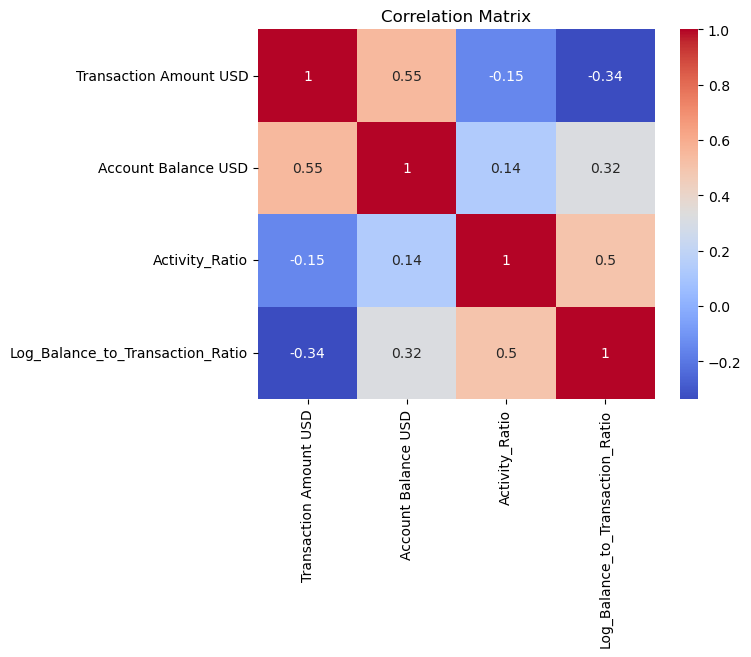

In [558]:
correlation_matrix = df[['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Log_Balance_to_Transaction_Ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [559]:
print(df.columns)

Index(['Branch', 'Transaction Amount', 'Account Balance',
       'Transaction Amount USD', 'Account Balance USD',
       'Balance_to_Transaction_Ratio', 'Log_Balance_to_Transaction_Ratio',
       'Transaction_To_Balance_Ratio', 'Activity_Ratio', 'Log_Activity_Ratio',
       'Account_Type_Current', 'Account_Type_Fixed Deposit',
       'Account_Type_Recurring Deposit', 'Account_Type_Savings',
       'Account_Balance_Relative_to_Mean_AccType', 'Transaction_Type_0',
       'Transaction_Type_1', 'Transaction_Amount_Relative_to_Mean_TransType',
       'Currency_EUR', 'Currency_GBP', 'Currency_INR', 'Currency_JPY',
       'Currency_USD'],
      dtype='object')


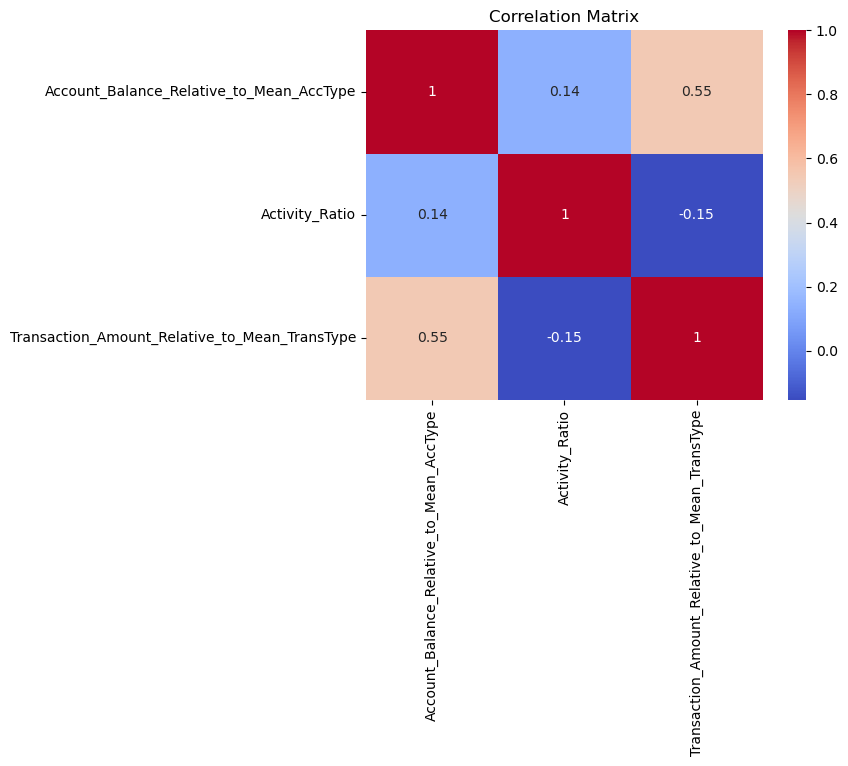

In [560]:
correlation_matrix = df[['Account_Balance_Relative_to_Mean_AccType', 'Activity_Ratio', 'Transaction_Amount_Relative_to_Mean_TransType']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [561]:
df.describe()

,Transaction Amount,Account Balance,Transaction Amount USD,Account Balance USD,Balance_to_Transaction_Ratio,Log_Balance_to_Transaction_Ratio,Transaction_To_Balance_Ratio,Activity_Ratio,Log_Activity_Ratio,Account_Balance_Relative_to_Mean_AccType,Transaction_Amount_Relative_to_Mean_TransType
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2524.564298,50269.794260,1704.556596,33910.047464,61.379967,3.093531,0.173226,51.598017,3.053764,1.000000,1.000000
std,1444.318039,29057.726646,1870.159242,37213.913721,252.298729,1.220871,0.910253,188.571262,1.178313,1.097756,1.097354
min,10.970000,101.890000,0.082434,0.897336,0.026799,0.026447,0.000122,0.026793,0.026440,0.000027,0.000049
25%,1263.912500,24863.487500,26.736683,535.726967,9.917744,2.390389,0.025296,9.700183,2.370261,0.015856,0.015674
50%,2544.655000,50790.475000,950.329000,18802.265000,19.914487,3.040442,0.050215,19.591474,3.024877,0.551807,0.555584
75%,3781.757500,75128.187500,3277.854375,65177.548200,39.532359,3.702101,0.100829,38.292693,3.671039,1.917627,1.922620
max,4999.790000,99975.590000,6347.510800,126968.999300,8163.276436,9.007523,37.314359,7535.814758,8.927555,3.847178,3.775900


c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

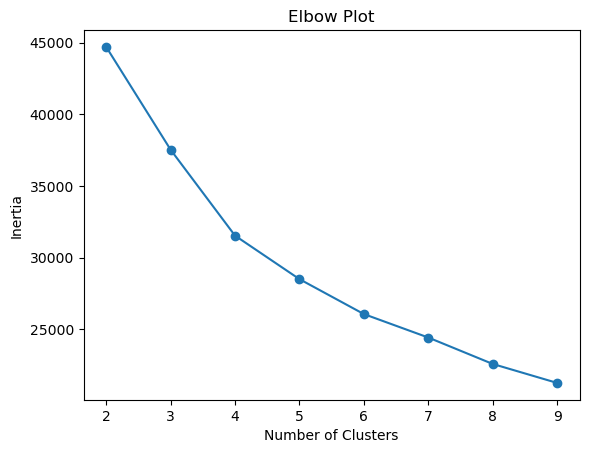

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Wybór cech do klasteryzacji
features = ['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Log_Balance_to_Transaction_Ratio', 'Transaction_Amount_Relative_to_Mean'] + \
           [col for col in df.columns if col.startswith('Account_Type_') or col.startswith('Currency_')]

# Określenie optymalnej liczby klastrów
inertias = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[features])
    inertias.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(df[features], kmeans.labels_))

# Wykres elbow
plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Klasteryzacja z wybraną liczbą klastrów
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

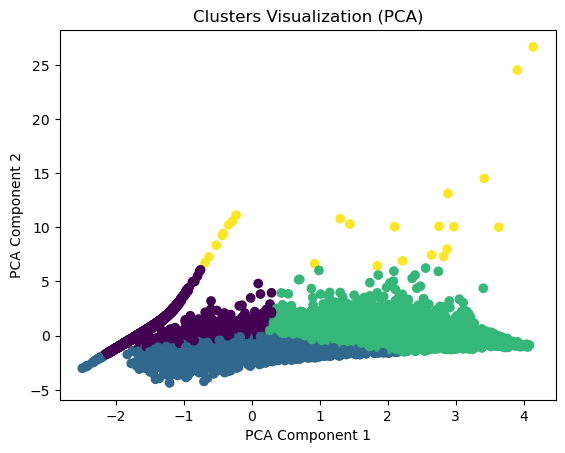

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[features])
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

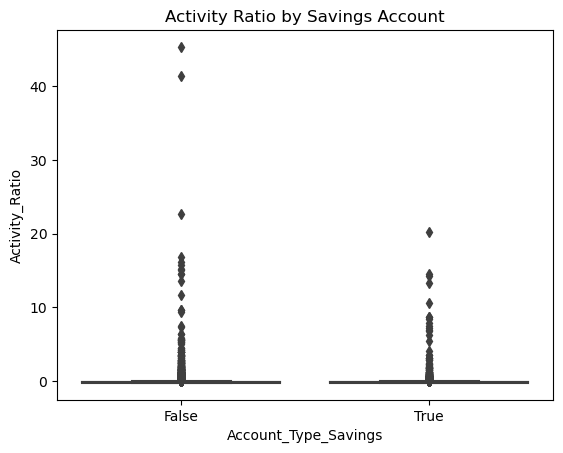

In [ ]:
sns.boxplot(x='Account_Type_Savings', y='Activity_Ratio', data=df)
plt.title('Activity Ratio by Savings Account')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(df[features], df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2938502721891494


### coś nie idzie

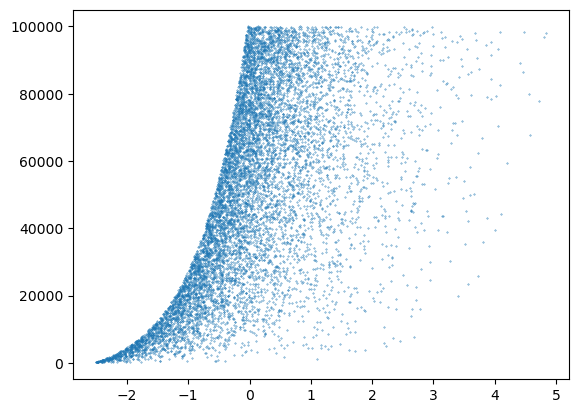

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account Balance'], s=0.1)
plt.show()

### Preprocessing

In [ ]:
print(df.columns)

Index(['Branch', 'Transaction Type', 'Transaction Amount', 'Account Balance',
       'Transaction Amount USD', 'Account Balance USD',
       'Balance_to_Transaction_Ratio', 'Log_Balance_to_Transaction_Ratio',
       'Transaction_To_Balance_Ratio', 'Log_Transaction_To_Balance_Ratio',
       'Activity_Ratio', 'Account_Type_Current', 'Account_Type_Fixed Deposit',
       'Account_Type_Recurring Deposit', 'Account_Type_Savings',
       'Transaction_Amount_Relative_to_Mean', 'Currency_EUR', 'Currency_GBP',
       'Currency_INR', 'Currency_JPY', 'Currency_USD', 'Log_Activity_Ratio',
       'Cluster'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Account_Type_Current '] = le.fit_transform(df['Account_Type_Current'])
df['Transaction Type'] = le.fit_transform(df['Transaction Type'])
df['Branch'] = le.fit_transform(df['Branch'])

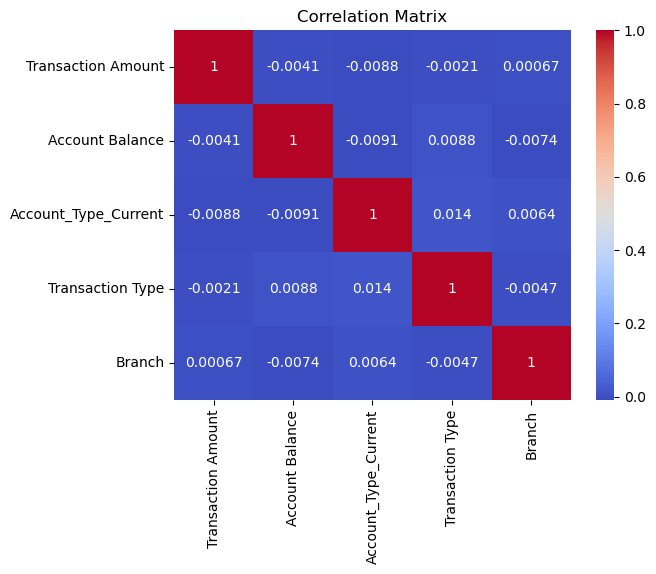

In [ ]:
cm = df[['Transaction Amount', 'Account Balance', 'Account_Type_Current', 'Transaction Type', 'Branch']].corr()
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

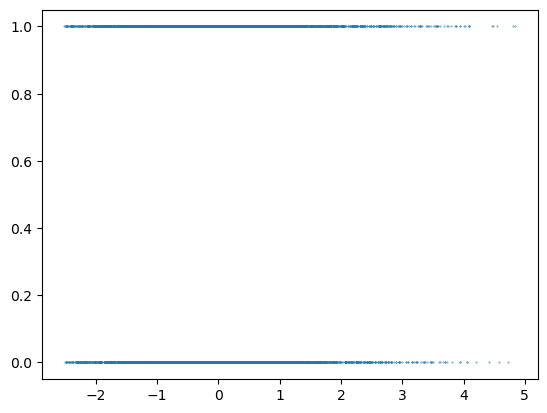

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Transaction Type'], s=0.1)
plt.show()

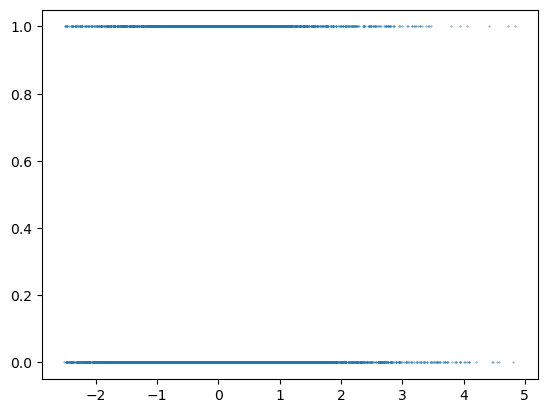

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account_Type_Current'], s=0.1)
plt.show()

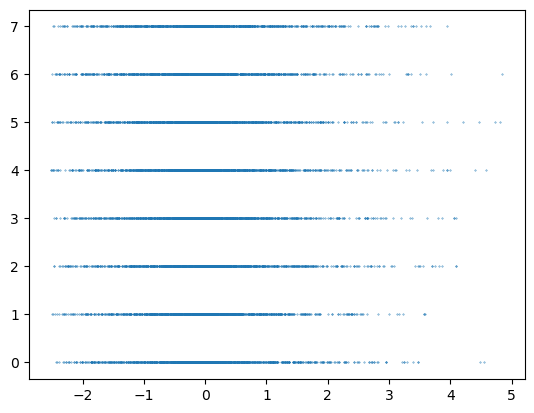

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Branch'], s=0.1)
plt.show()

### Jakieś próby klasteryzacji

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


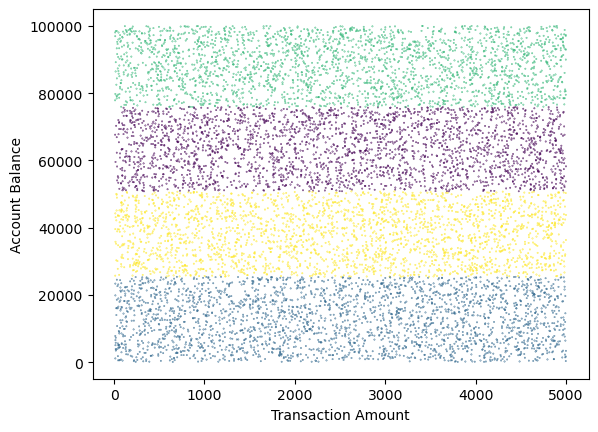

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)

df['Cluster'] = kmeans.fit_predict(df[['Transaction Amount', 'Account Balance', 'Account_Type_Current', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])

plt.scatter(df['Transaction Amount'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.show()

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

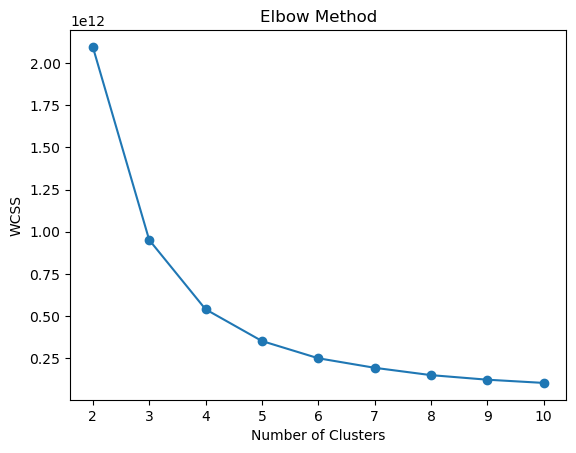

In [ ]:
wcss = []
scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['Transaction Amount', 'Account Balance', 'Account_Type_Current', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])
    wcss.append(kmeans.inertia_)
    scores.append(silhouette_score(df[['Transaction Amount', 'Account Balance', 'Account_Type_Current', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']], kmeans.labels_))

# Elbow plot
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

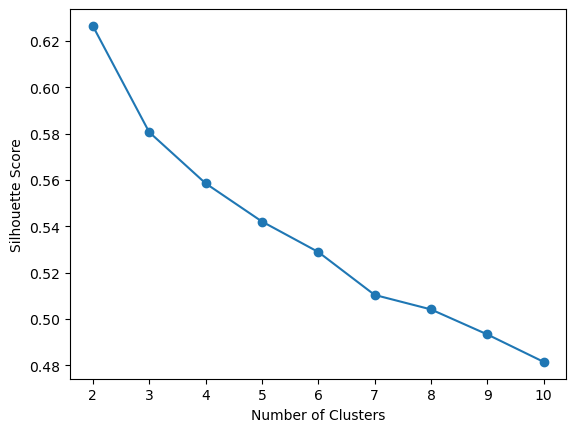

In [ ]:
plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


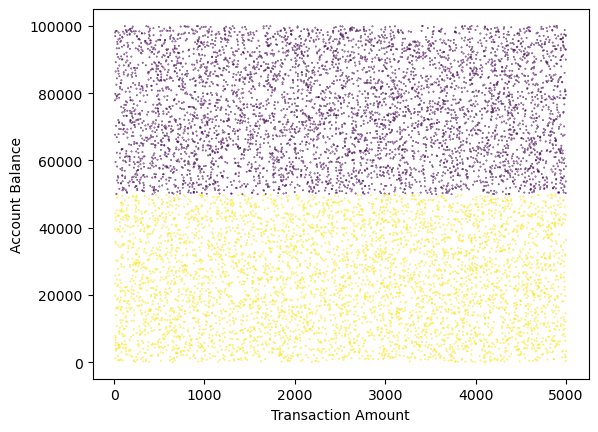

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)

df['Cluster'] = kmeans.fit_predict(df[['Transaction Amount', 'Account Balance', 'Account_Type_Current', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])

plt.scatter(df['Transaction Amount'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.show()

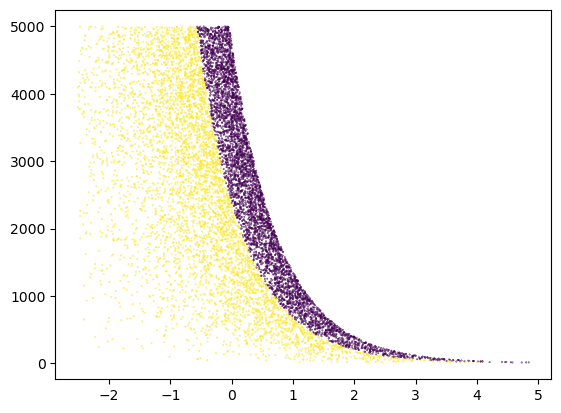

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Transaction Amount'], s=0.1, c=df['Cluster'])
plt.show()

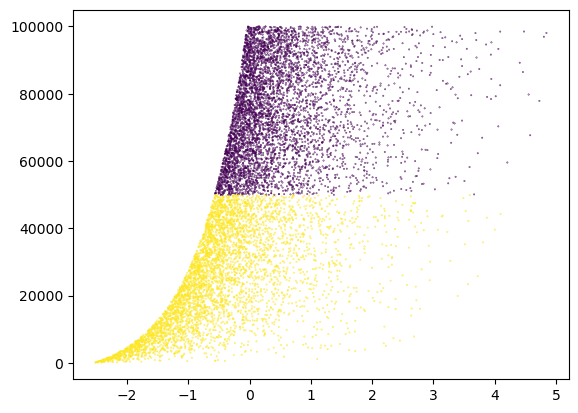

In [ ]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.show()

# Dostaliśmy bardzo ważne uwagi od zespołu walidacyjnego. Klasteryzacja jeszcze raz

In [ ]:
print(df.columns)

Index(['Branch', 'Transaction Type', 'Transaction Amount', 'Account Balance',
       'Transaction Amount USD', 'Account Balance USD',
       'Balance_to_Transaction_Ratio', 'Log_Balance_to_Transaction_Ratio',
       'Transaction_To_Balance_Ratio', 'Log_Transaction_To_Balance_Ratio',
       'Activity_Ratio', 'Account_Type_Current', 'Account_Type_Fixed Deposit',
       'Account_Type_Recurring Deposit', 'Account_Type_Savings',
       'Transaction_Amount_Relative_to_Mean', 'Currency_EUR', 'Currency_GBP',
       'Currency_INR', 'Currency_JPY', 'Currency_USD', 'Log_Activity_Ratio',
       'Cluster', 'Account_Type_Current '],
      dtype='object')


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = ['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Transaction_Amount_Relative_to_Mean'] + \
           [col for col in df.columns if col.startswith('Account_Type_') or col.startswith('Currency_')]

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

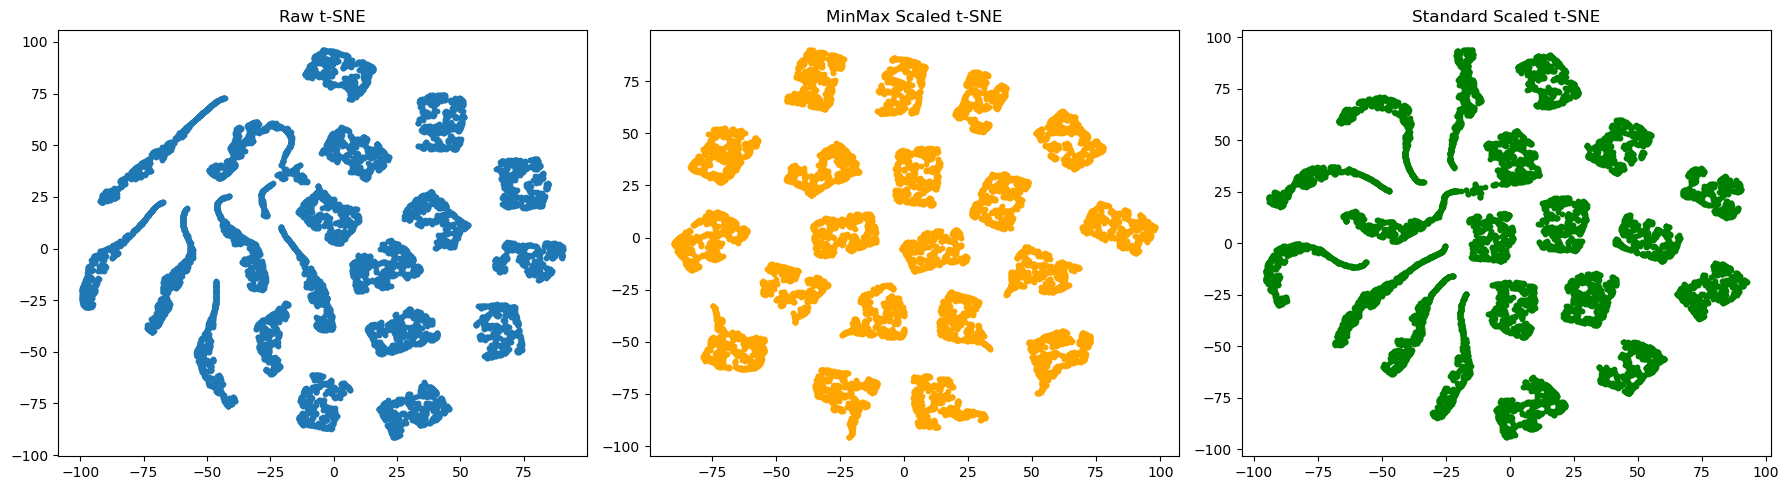

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

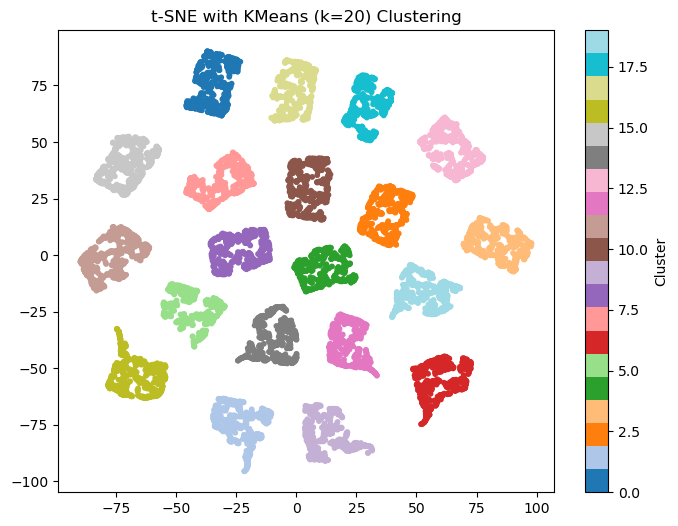

In [ ]:
# K-Means dla X_minmax
kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_minmax)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# Tworzenie wykresów
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab20', s=10)
plt.title('t-SNE with KMeans (k=20) Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

tutaj bez uwzgledniania zmiany waluty i z log_balance_to_ratio

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = ['Transaction Amount', 'Account Balance', 'Log_Balance_to_Transaction_Ratio', 'Transaction_Amount_Relative_to_Mean']

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

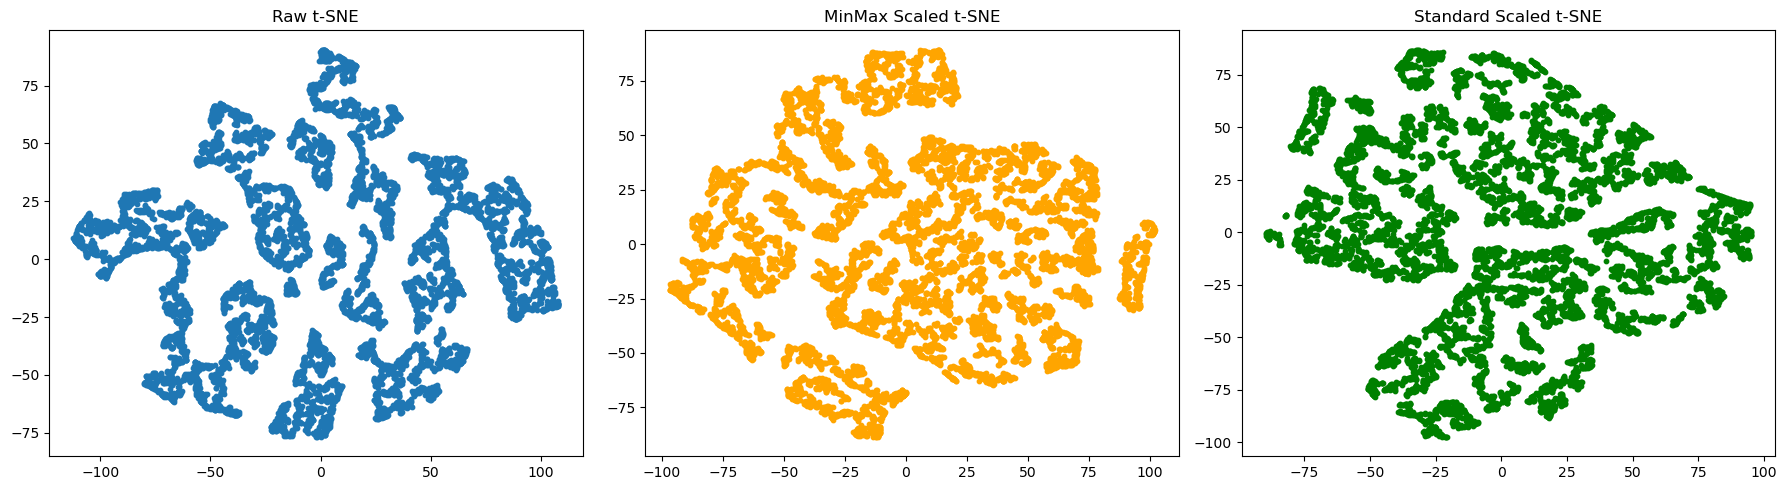

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

klastry są dużo gorsze. 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = ['Transaction Amount USD', 'Account Balance USD', 'Log_Balance_to_Transaction_Ratio USD', 'Transaction_Amount_Relative_to_Mean'] + \
           [col for col in df.columns if col.startswith('Account_Type_') or col.startswith('Currency_')]

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

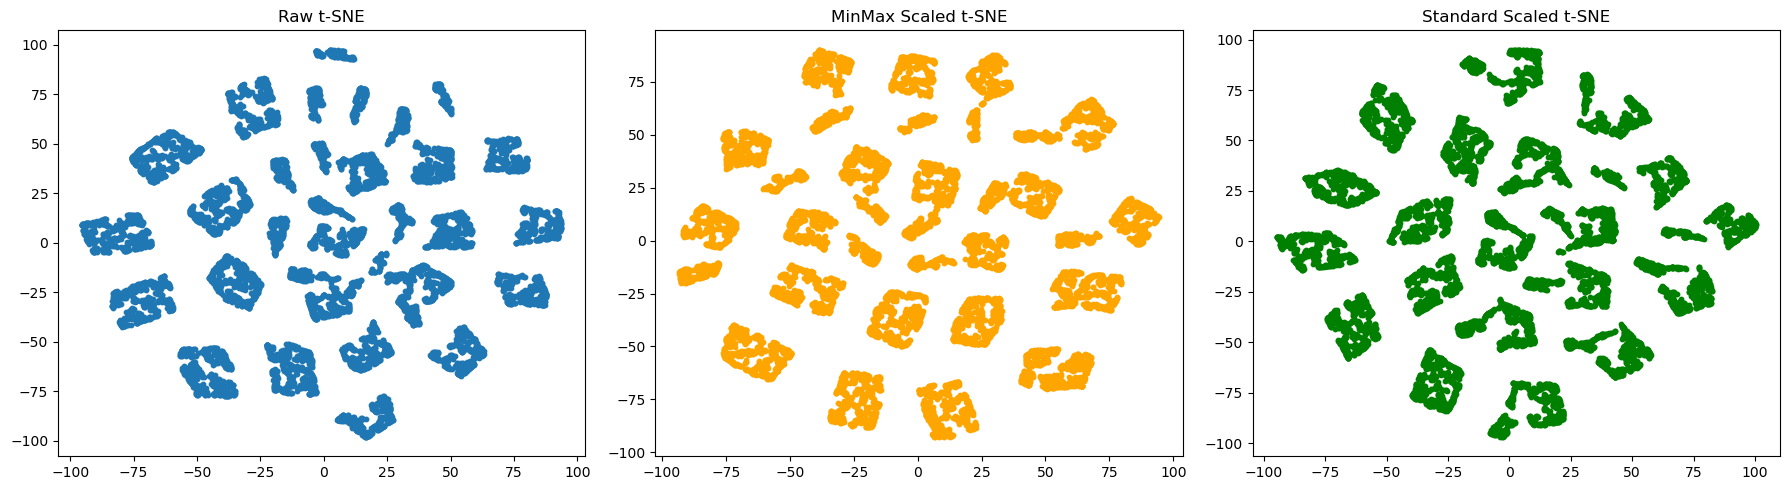

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

Tutaj te klastry mają dosyć podobne klastry, ale są mniej skupione. - możliwe, że Activity Ratio jest lepsze.

PCA raz jeszcze

In [ ]:
def get_variance(df, n):
    
    global df_t
    
    pca = PCA(n_components=n)

    pca.fit_transform(df)
    
    df_t = pca.explained_variance_ratio_

    return pca.explained_variance_ratio_.cumsum()[-1:]

In [ ]:
for i in range(0, len(features)):
    print('Principal Components PC' + str(i) + ':' + str(get_variance(X, i+1)) +  
          '\tCumulative Proportion')

Principal Components PC0:[0.50567022]	Cumulative Proportion
Principal Components PC1:[0.6273707]	Cumulative Proportion
Principal Components PC2:[0.71442419]	Cumulative Proportion
Principal Components PC3:[0.77331431]	Cumulative Proportion
Principal Components PC4:[0.82346013]	Cumulative Proportion
Principal Components PC5:[0.87169123]	Cumulative Proportion
Principal Components PC6:[0.91163914]	Cumulative Proportion
Principal Components PC7:[0.95095023]	Cumulative Proportion
Principal Components PC8:[0.98995204]	Cumulative Proportion
Principal Components PC9:[0.9999922]	Cumulative Proportion
Principal Components PC10:[1.]	Cumulative Proportion
Principal Components PC11:[1.]	Cumulative Proportion
Principal Components PC12:[1.]	Cumulative Proportion
Principal Components PC13:[1.]	Cumulative Proportion


In [ ]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

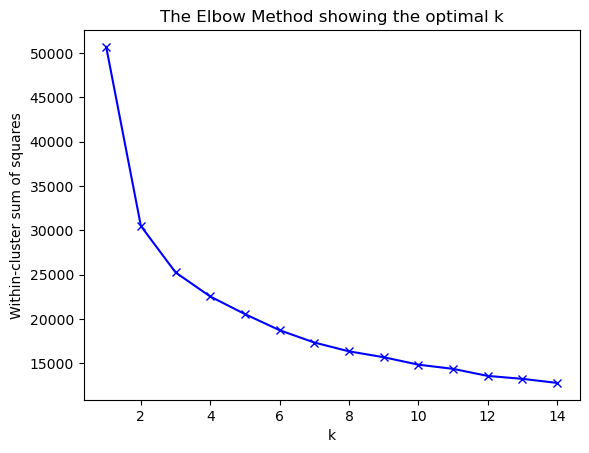

In [ ]:
wcss_vec = count_wcss_scores(X, 14)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

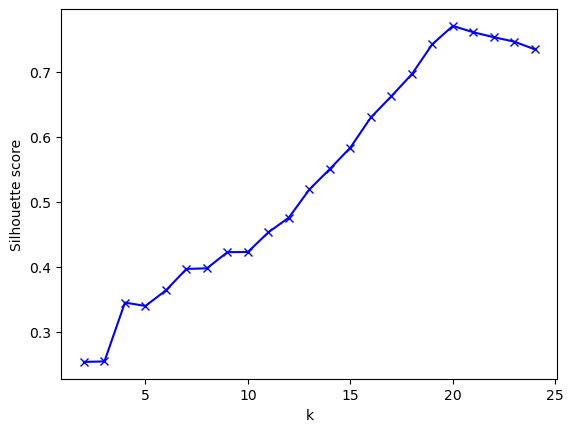

In [ ]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 25) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X_minmax, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

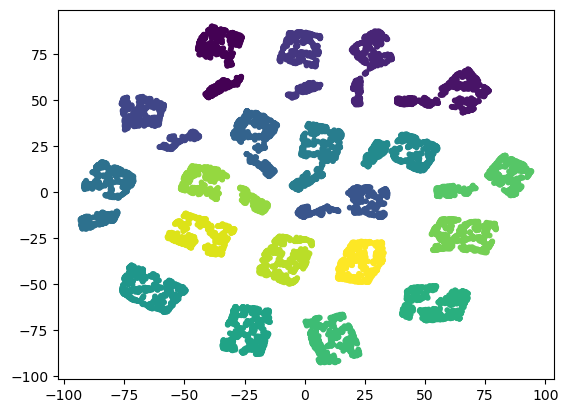

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=20)
plt.scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], c=y, s=10, cmap='viridis')
plt.show()

# NOWE FEATURES I PRÓBA JESZCZE RAZ

In [569]:
print(df.columns)

Index(['Branch', 'Transaction Amount', 'Account Balance',
       'Transaction Amount USD', 'Account Balance USD',
       'Balance_to_Transaction_Ratio', 'Log_Balance_to_Transaction_Ratio',
       'Transaction_To_Balance_Ratio', 'Activity_Ratio', 'Log_Activity_Ratio',
       'Account_Type_Current', 'Account_Type_Fixed Deposit',
       'Account_Type_Recurring Deposit', 'Account_Type_Savings',
       'Account_Balance_Relative_to_Mean_AccType', 'Transaction_Type_0',
       'Transaction_Type_1', 'Transaction_Amount_Relative_to_Mean_TransType',
       'Currency_EUR', 'Currency_GBP', 'Currency_INR', 'Currency_JPY',
       'Currency_USD'],
      dtype='object')


In [574]:
features = ['Account Balance USD', 'Transaction Amount USD','Log_Activity_Ratio', 'Account_Balance_Relative_to_Mean_AccType', 'Transaction_Amount_Relative_to_Mean_TransType'] + \
           [col for col in df.columns if col.startswith('Account_Type_') or col.startswith('Currency_')]

In [575]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

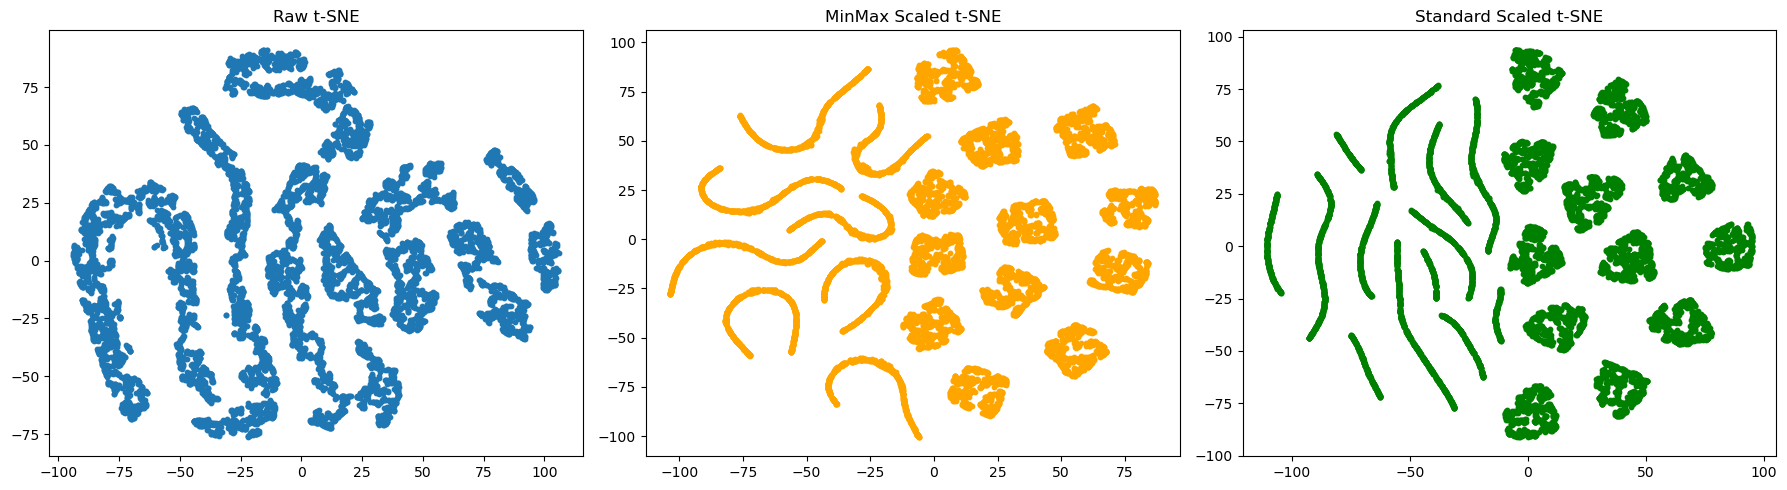

In [576]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

20 klastrów w MinMax, 25 Klastrów w Standard

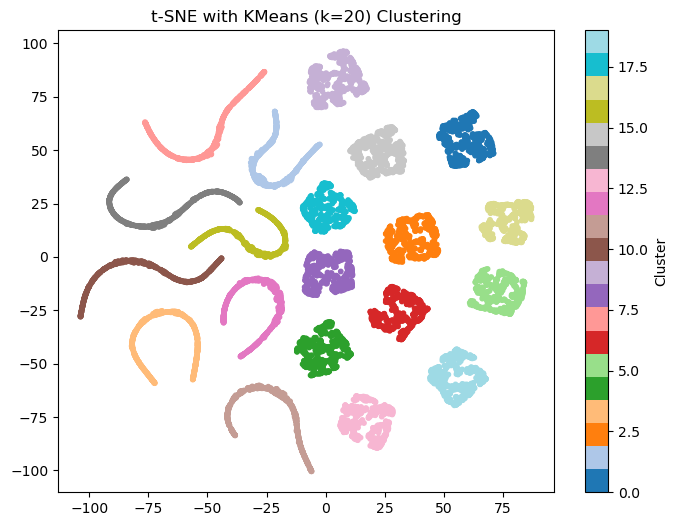

In [577]:
kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_minmax)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# Tworzenie wykresów
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab20', s=10)
plt.title('t-SNE with KMeans (k=20) Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

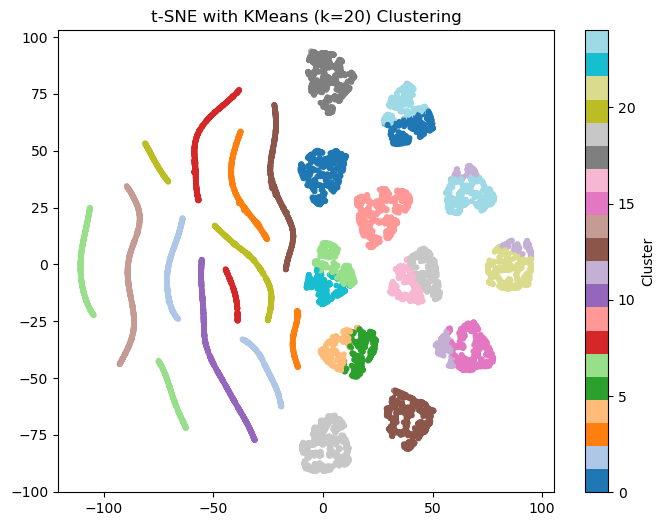

In [579]:
kmeans = KMeans(n_clusters=25, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_standard)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

# Tworzenie wykresów
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab20', s=10)
plt.title('t-SNE with KMeans (k=20) Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

W min max łatwiej jest dobrać liczbę klastrów

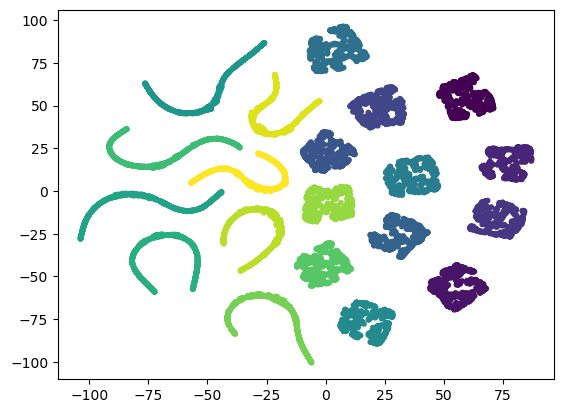

In [580]:
model = AgglomerativeClustering(n_clusters=20)
plt.scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], c=y, s=10, cmap='viridis')
plt.show()

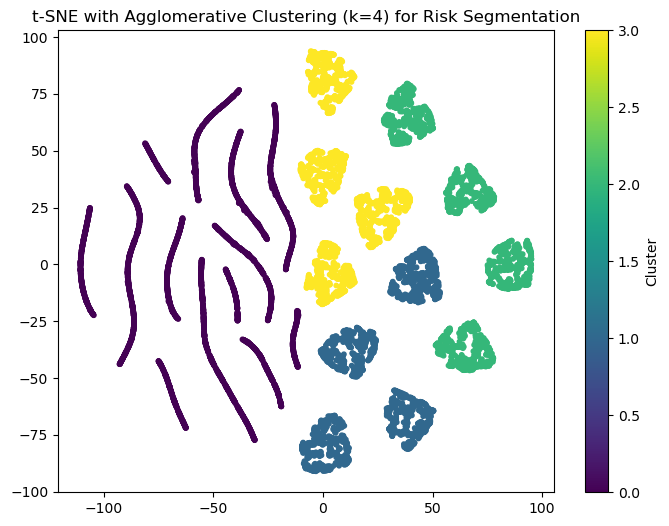

NameError: name 'linkage' is not defined

In [581]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Klasteryzacja hierarchiczna (AgglomerativeClustering)
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = model.fit_predict(X_scaled)

# Redukcja wymiarowości za pomocą t-SNE do wizualizacji
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

# Wizualizacja wyników klasteryzacji
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE with Agglomerative Clustering (k=4) for Risk Segmentation')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Dendrogram dla klasteryzacji hierarchicznej
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

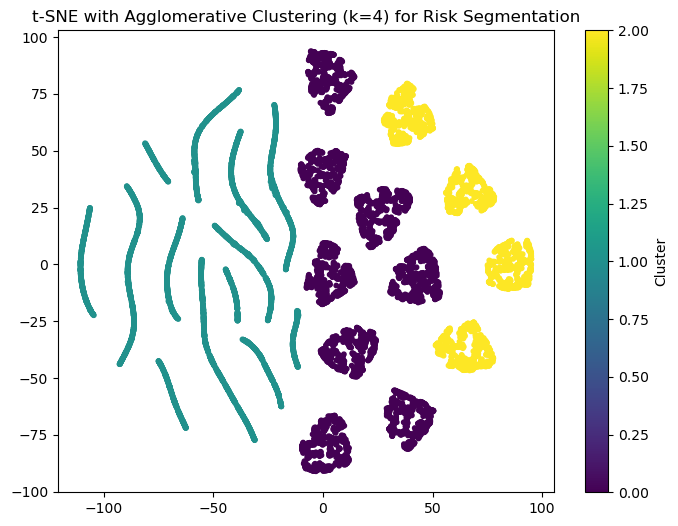

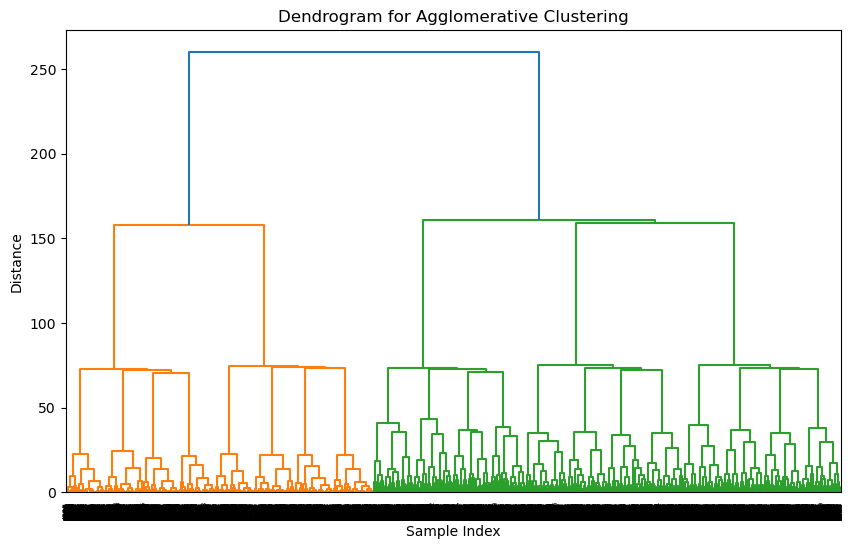

In [582]:
from scipy.cluster.hierarchy import dendrogram, linkage

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Klasteryzacja hierarchiczna (AgglomerativeClustering)
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = model.fit_predict(X_scaled)

# Redukcja wymiarowości za pomocą t-SNE do wizualizacji
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

# Wizualizacja wyników klasteryzacji
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE with Agglomerative Clustering (k=4) for Risk Segmentation')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Dendrogram dla klasteryzacji hierarchicznej
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

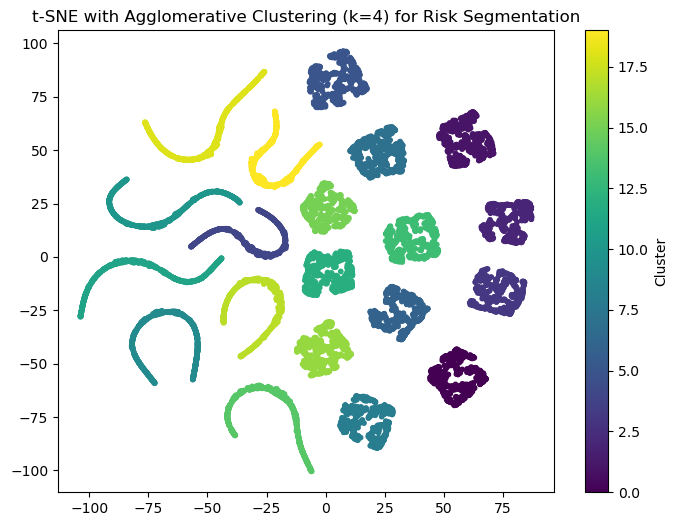

In [584]:
# Klasteryzacja hierarchiczna (AgglomerativeClustering)
model = AgglomerativeClustering(n_clusters=20, linkage='ward')
labels = model.fit_predict(X_minmax)

# Redukcja wymiarowości za pomocą t-SNE do wizualizacji
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# Wizualizacja wyników klasteryzacji
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE with Agglomerative Clustering (k=4) for Risk Segmentation')
plt.colorbar(scatter, label='Cluster')
plt.show()

